# Preparing Training Data from Paired scRNA/TCR-seq

This tutorial demonstrates how to prepare paired scRNA/TCR-seq data as an input for model training and optimization.

## Example Dataset

We use a publicly available paired scRNA/TCR-seq dataset of patients with brain tumors from:

- **Study**: Wang et al. 2024
- **Source**: https://zenodo.org/records/10672442
- **Data type**: Paired scRNA/TCR-seq
- **Cancer type**: Brain
- **Tissue**: Tumor and Blood samples

## Workflow Overview

1. **Data Loading & Quality Control** - Load scRNA-seq data, filter low-quality cells, remove doublets
2. **scTCR-seq Processing** - Load scTCR-seq data, filter multichain/orphan TCRs, define clonotypes
3. **Cell Type Classification** - Apply MAGIC imputation, determine expression cutoffs, classify T-cell subtypes
4. **Integration** - Combine scRNA-seq and TCR-seq annotations, add metadata
5. **Clonal Expansion** - Calculate clone sizes per sample, determine expansion status
6. **Export** - Save processed data

---

## **Important note (!):**

This tutorial was made available to **examplify the process** we conducted to prepare the data as an input for model training, using just one dataset as an example.

It is highly recommended to directly use our pre-trained models rather than training them 'De-Novo' by yourselves.

## 1. Data Loading & Quality Control using [Scanpy](https://github.com/scverse/scanpy)

### 1.1 Loading scRNA-seq Data

In this section, we load the scRNA-seq data and concatenate multiple samples into a unified AnnData object.

In [1]:
# Check required packages
import importlib.util

missing_packages = []
for package in ["magic", "muon"]:
    if importlib.util.find_spec(package) is None:
        missing_packages.append(package)

if missing_packages:
    print(f"Missing packages: {', '.join(missing_packages)}")
    print("Install with: pip install muon magic-impute")
    print(
        "Docs: https://muon.readthedocs.io | https://github.com/KrishnaswamyLab/MAGIC"
    )

In [2]:
# Import required libraries for data analysis, visualization, and single-cell processing
import os
import sys
from pathlib import Path

import anndata as ad
import matplotlib.pyplot as plt
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir
import seaborn as sns
from scipy.signal import argrelextrema, find_peaks

# Set matplotlib backend for Jupyter notebooks
%matplotlib inline

# Plotting settings
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["axes.axisbelow"] = True
sns.set_style("whitegrid")

# Setup project paths
project_root = Path.cwd().parent.parent
print(f"Project root: {project_root}")
sys.path.insert(0, str(project_root))

Project root: /Users/rona/repos/scXpand-1


We use [Pooch](https://github.com/fatiando/pooch) to download the data from Zenodo:

In [3]:
# Download the dataset from Zenodo and extract to demo directory
import pooch

demo_path = project_root / "data" / "demo"
cache_dir = demo_path / ".zenodo_cache"

# Create directories
cache_dir.mkdir(exist_ok=True, parents=True)
demo_path.mkdir(exist_ok=True, parents=True)

# Construct Zenodo download URL
zenodo_record_id = "10672442"
filename = "Raw_files.zip"
zenodo_url = f"https://zenodo.org/records/{zenodo_record_id}/files/{filename}"

# Download and extract using Pooch
downloaded_files = pooch.retrieve(
    url=zenodo_url,
    known_hash=None,  # Let Pooch compute hash automatically
    path=str(cache_dir),
    progressbar=True,
    processor=pooch.Unzip(extract_dir=str(demo_path)),
)

source_path = demo_path / "Raw_files"

In [4]:
# Identify all sample directories in the dataset (excluding files and 'Grex' folder)
samples = [
    s for s in os.listdir(source_path) if (source_path / s).is_dir() and s != "Grex"
]

print(f"Found {len(samples)} sample directories: {samples}")

Found 26 sample directories: ['GBM113_PBMC', 'GBM111Re_TIL', 'GBM074', 'GBM111Re_PBMC', 'GBM056', 'G4A062', 'G4A065Re', 'BrMet028', 'G4A112Re_TIL', 'BrMet010', 'GBM115', 'BrMet027', 'BrMet018', 'GBM114_PBMC', 'GBM105', 'BrMet009', 'GBM064', 'GBM063', 'GBM114_TIL', 'GBM091', 'GBM098', 'GBM106_PBMC', 'GBM106_TIL', 'GBM113_TIL', 'G4A112Re_PBMC', 'GBM104Re']


In [5]:
# Define helper function to load scRNA-seq data and initialize AnnData object with first sample
def load_sample_data(source_path: Path, sample: str) -> ad.AnnData:
    """Load and prepare scRNA-seq data for a single sample (optionally subset to first n_cells)."""
    adata = sc.read_10x_mtx(source_path / sample / "filtered_feature_bc_matrix")

    adata.obs["sample"] = sample
    adata.obs_names = [f"{name.split('-')[0]}_{sample}" for name in adata.obs_names]
    return adata


# Load first sample:
adata = load_sample_data(source_path, samples[0])
adata

AnnData object with n_obs × n_vars = 5259 × 33538
    obs: 'sample'
    var: 'gene_ids', 'feature_types'

In [6]:
# Concatenate all remaining samples into a single AnnData object
for sample in samples[1:]:
    tmp = load_sample_data(source_path, sample)
    adata = ad.concat([adata, tmp])

In [7]:
# Ensure consistent gene metadata across all samples
adata.var = tmp.var.loc[adata.var_names]

In [8]:
# Display the combined dataset
adata

AnnData object with n_obs × n_vars = 110489 × 31915
    obs: 'sample'
    var: 'gene_ids', 'feature_types'

### 1.2 Quality Control

We perform initial quality control to identify and filter low-quality cells and genes.

In [9]:
# Mark mitochondrial genes for quality control
adata.var["mt"] = adata.var_names.str.startswith("MT-")

In [10]:
# Calculate quality control metric of mitochondrial gene percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

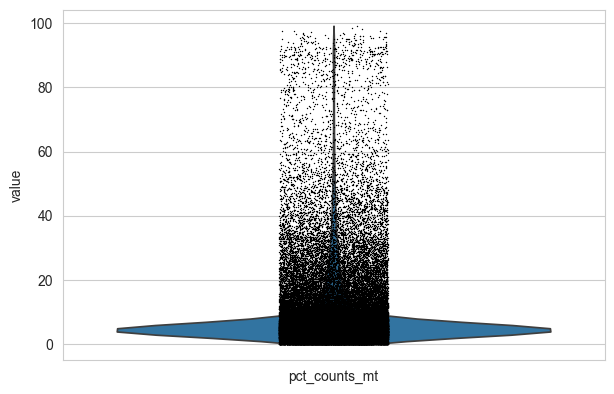

In [11]:
# Visualize distribution of mitochondrial gene percentage across cells
sc.pl.violin(adata, "pct_counts_mt", jitter=0.1)

In [12]:
# Filter cells with high mitochondrial content (>10%), low gene count, and rare genes
adata = adata[adata.obs.pct_counts_mt < 10, :]
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

/Users/rona/repos/scXpand-1/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


AnnData object with n_obs × n_vars = 92033 × 23328
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

#### 1.2.1 Doublet Detection and Removal

We use [Scrublet](https://github.com/swolock/scrublet) to detect and remove doublets.

In [13]:
# Run Scrublet doublet detection
sc.pp.scrublet(
    adata,
    expected_doublet_rate=0.05,  # Expected doublet rate for the dataset
    batch_key="sample",  # Process each sample separately
    random_state=42,  # For reproducibility
)

#  Original code used in our dataset generation (replaced with scanpy's implementation due to compatibility issues in non-Windows environments):
#  import scrublet as scr
#  scrub = scr.Scrublet(adata.X, expected_doublet_rate=0.05)
#  adata.obs["doublet_scores"], adata.obs["predicted_doublets"] = scrub.scrub_doublets()

In [14]:
# Plot histogram of doublet scores (optional)
# sc.pl.scrublet_score_distribution(adata)

In [15]:
# Remove cells with high doublet scores using a conservative threshold of 0.3
doublet_threshold = 0.3
adata = adata[adata.obs["doublet_score"] < doublet_threshold]
print(f"Remaining cells after doublet filtering: {adata.n_obs}")

Remaining cells after doublet filtering: 91079


We preserve raw counts and annotate samples with tissue type information.

In [16]:
# Store raw counts in a separate layer for future use
adata.layers["counts"] = adata.X.copy()

/var/folders/gj/lml42yl53zj8xfsrl3r6dhr80000gn/T/ipykernel_76547/1076825918.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


In [17]:
# Assign tissue type based on sample name (PBMC = Blood, others = Tumor)
adata.obs["tissue_type"] = np.where(
    adata.obs["sample"].str.contains("PBMC"), "Blood", "Tumor"
)

## 2. scTCR-seq Processing

### 2.1 Loading and Quality Control of scTCR-seq Data using [Scirpy](https://github.com/scverse/scirpy)

In this section, we load scTCR-seq data and perform quality control to ensure high-quality T-cell receptor information.

In [18]:
# Define helper function to load scTCR-seq data and load first sample
def load_tcr_sample(source_path: Path, sample: str) -> ad.AnnData | None:
    """Load and prepare 10X VDJ data for a single sample (returns None if file doesn't exist)."""
    tcr_path = source_path / sample / "filtered_contig_annotations.csv"
    if not tcr_path.exists():
        return None
    adata_tcr = ir.io.read_10x_vdj(tcr_path)
    adata_tcr.obs_names = [
        f"{name.split('-')[0]}_{sample}" for name in adata_tcr.obs_names
    ]
    return adata_tcr


# Load first sample:
adata_tcr = load_tcr_sample(source_path, samples[0])
adata_tcr

/Users/rona/repos/scXpand-1/.venv/lib/python3.13/site-packages/airr/schema.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream


/Users/rona/repos/scXpand-1/.venv/lib/python3.13/site-packages/anndata/utils.py:362: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


AnnData object with n_obs × n_vars = 1622 × 0
    uns: 'scirpy_version'
    obsm: 'airr'

In [19]:
# Concatenate TCR data from all remaining samples
for sample in samples[1:]:
    tmp = load_tcr_sample(source_path, sample)
    if tmp is not None:
        adata_tcr = ad.concat([adata_tcr, tmp])

In [20]:
# Index TCR chains and perform quality control
ir.pp.index_chains(adata_tcr)
ir.tl.chain_qc(adata_tcr)

<Axes: title={'center': 'Number of cells in receptor_subtype by has_ir'}, xlabel='receptor_subtype', ylabel='Number of cells'>

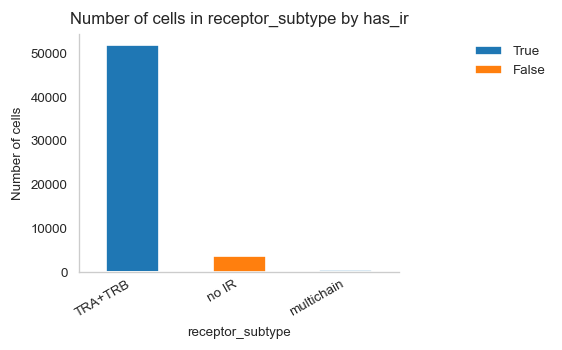

In [21]:
# Visualize abundance of different receptor subtypes
ir.pl.group_abundance(adata_tcr, groupby="receptor_subtype")

In [22]:
# Display amount of cells per receptor subtype
adata_tcr.obs.groupby("receptor_subtype").size()

receptor_subtype
TRA+TRB       51779
multichain      406
no IR          3755
dtype: int64

In [23]:
# Calculate and display the fraction of cells with more than one pair of productive TCRs
multichain_types = ["extra VJ", "extra VDJ", "two full chains", "multichain"]
multichain_fraction = adata_tcr.obs["chain_pairing"].isin(multichain_types).mean()
print(f"Fraction of cells with more than one pair of TCRs: {multichain_fraction:.2f}")

Fraction of cells with more than one pair of TCRs: 0.09


### 2.2 TCR Quality Control and Filtering

We filter out cells:
- Cells with multiple TCR pairs (multichain)
- Cells with orphan chains (incomplete TCR pairs)
- Cells with no immune receptor detected

In [24]:
# Filter out cells with multichain TCRs
mu.pp.filter_obs(adata_tcr, "chain_pairing", lambda x: x != "multichain")
adata_tcr

AnnData object with n_obs × n_vars = 55534 × 0
    obs: 'receptor_type', 'receptor_subtype', 'chain_pairing'
    uns: 'chain_indices'
    obsm: 'airr', 'chain_indices'

In [25]:
# Remove cells with orphan chains (don’t have at least one full pair of receptor sequences)
mu.pp.filter_obs(
    adata_tcr, "chain_pairing", lambda x: ~np.isin(x, ["orphan VDJ", "orphan VJ"])
)
adata_tcr

AnnData object with n_obs × n_vars = 42834 × 0
    obs: 'receptor_type', 'receptor_subtype', 'chain_pairing'
    uns: 'chain_indices'
    obsm: 'airr', 'chain_indices'

In [26]:
# Filter out cells with no immune receptor detected
adata_tcr = adata_tcr[adata_tcr.obs["receptor_subtype"] != "no IR"]
adata_tcr

View of AnnData object with n_obs × n_vars = 39079 × 0
    obs: 'receptor_type', 'receptor_subtype', 'chain_pairing'
    uns: 'chain_indices'
    obsm: 'airr', 'chain_indices'

### 2.3 Clonotype Definition

We define clonotypes by calculating TCR sequence distances and grouping cells with identical TCR sequences.

In [27]:
# Calculate TCR sequence distance matrix for clonotype definition
ir.pp.ir_dist(adata_tcr)

/Users/rona/repos/scXpand-1/.venv/lib/python3.13/site-packages/scirpy/ir_dist/__init__.py:267: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  params.adata.uns[key_added] = result


In [28]:
# Define clonotypes (cells with identical TCR sequences)
# We require the CDR3 nucleic acid sequence in both chains to match exactly, and consider the most abundant pair of chains in case of dual TCRs
ir.tl.define_clonotypes(adata_tcr, receptor_arms="all", dual_ir="primary_only")

### 2.4 Integration with scRNA-seq Data

We merge the scTCR-seq data with the scRNA-seq data, keeping only cells that have both types of data.

In [29]:
# Keep only cells that have both scRNA-seq and TCR-seq data
adata = adata[adata.obs_names.isin(adata_tcr.obs_names)].copy()

## 3. Cell Type Classification

### Important Note

[MAGIC](https://github.com/KrishnaswamyLab/MAGIC) (Markov Affinity-based Graph Imputation of Cells) is a powerful technique for denoising single-cell data and imputing missing values. It helps recover true biological signals by leveraging the manifold structure of the data.

In this tutorial, we use MAGIC to improve the detection of key T-cell markers (CD8A, CD8B, CD4, FOXP3) for accurate cell type classification.

### 3.1 Processing Tumor Samples

We begin by processing tumor samples, applying MAGIC imputation to enhance marker gene detection.

In [30]:
# Subset data to tumor samples only
adata_tumor = adata[adata.obs["tissue_type"] == "Tumor"]

In [31]:
# Normalize and log-transform tumor data (target sum = 10,000, log base 2)
sc.pp.normalize_total(adata_tumor, target_sum=1e4)
sc.pp.log1p(adata_tumor, base=2)

/Users/rona/repos/scXpand-1/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


#### 3.1.1 MAGIC Imputation for Tumor Samples

MAGIC imputation is applied to denoise the expression of key T-cell marker genes.

In [32]:
# Apply MAGIC imputation to denoise and impute T-cell marker genes
adata_magic_tumor = sc.external.pp.magic(
    adata_tumor,
    name_list=["CD8A", "CD8B", "CD4", "FOXP3", "CD3E", "PTPRC"],
    random_state=42,
)

/Users/rona/repos/scXpand-1/.venv/lib/python3.13/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


In [33]:
# Extract original (non-imputed) gene expression values
non_imputed_df = sc.get.obs_df(adata_tumor, list(adata_magic_tumor.var_names))

In [34]:
# Combine MAGIC-imputed and original expression values into one dataframe
magic_df_tumor = sc.get.obs_df(adata_magic_tumor, list(adata_magic_tumor.var_names))
magic_df_tumor.columns = [f"{col}_Imputed" for col in magic_df_tumor.columns]
magic_df_tumor = magic_df_tumor.join(non_imputed_df)

In [35]:
# Save tumor MAGIC labels to compressed CSV
magic_df_tumor.to_csv(
    source_path / "Brain_zenodo_MAGIC_labels_tumor.csv.gz", compression="gzip"
)

#### 3.1.2 Cell Type Classification Functions

We define functions to classify T cells based on CD8 and CD4 expression, and to identify regulatory T cells (Tregs).

In [36]:
# Define complete vectorized pipeline for cell type classification with cutoffs
def classify_tissue_cells(
    df: pd.DataFrame, cd8a_cutoff: float, cd8b_cutoff: float, cd4_cutoff: float
) -> pd.DataFrame:
    """
    Complete classification pipeline using vectorized operations:
    1. Classify based on imputed expression (MAGIC)
    2. Classify based on original expression
    3. Reconcile both classifications
    4. Identify Treg cells
    """
    # Vectorized classification based on imputed expression:
    is_cd8a_imp = df["CD8A_Imputed"] > cd8a_cutoff
    is_cd8b_imp = df["CD8B_Imputed"] > cd8b_cutoff
    is_cd4_imp = df["CD4_Imputed"] > cd4_cutoff
    has_cd8_imp = is_cd8a_imp | is_cd8b_imp

    # Initialize and assign MAGIC cell types:
    df["MAGIC_Cell_Type"] = "Double_Negative"
    df.loc[has_cd8_imp & ~is_cd4_imp, "MAGIC_Cell_Type"] = "is_CD8"
    df.loc[~has_cd8_imp & is_cd4_imp, "MAGIC_Cell_Type"] = "is_CD4"
    df.loc[has_cd8_imp & is_cd4_imp, "MAGIC_Cell_Type"] = "Double_Positive"

    # Vectorized classification based on original expression:
    is_cd8a_orig = df["CD8A"] > 1
    is_cd8b_orig = df["CD8B"] > 1
    is_cd4_orig = df["CD4"] > 1
    has_cd8_orig = is_cd8a_orig | is_cd8b_orig

    # Initialize and assign original cell types:
    df["type_original"] = "Double_Negative"
    df.loc[has_cd8_orig & ~is_cd4_orig, "type_original"] = "is_CD8"
    df.loc[~has_cd8_orig & is_cd4_orig, "type_original"] = "is_CD4"
    df.loc[has_cd8_orig & is_cd4_orig, "type_original"] = "Double_Positive"

    # Vectorized reconciliation of classifications:
    df["final_type"] = df["type_original"].copy()

    # Apply reconciliation rules using boolean masks:
    cd8_mask = (df["type_original"] == "is_CD8") & df["MAGIC_Cell_Type"].isin(
        ["is_CD4", "Double_Negative", "is_CD8"]
    )
    df.loc[cd8_mask, "final_type"] = "is_CD8"

    cd4_mask = (df["type_original"] == "is_CD4") & df["MAGIC_Cell_Type"].isin(
        ["is_CD4", "Double_Negative", "is_CD8"]
    )
    df.loc[cd4_mask, "final_type"] = "is_CD4"

    double_pos_mask = df["type_original"].isin(["is_CD4", "is_CD8"]) & (
        df["MAGIC_Cell_Type"] == "Double_Positive"
    )
    df.loc[double_pos_mask, "final_type"] = "Double_Positive"

    double_neg_mask = df["type_original"] == "Double_Negative"
    df.loc[double_neg_mask, "final_type"] = df.loc[double_neg_mask, "MAGIC_Cell_Type"]

    # Vectorized Treg identification:
    treg_mask = (df["final_type"] == "is_CD4") & (
        (df["FOXP3"] > 1) | (df["FOXP3_Imputed"] > 1)
    )
    df.loc[treg_mask, "final_type"] = "is_Treg"

    return df

### 3.2 Determining Expression Cutoffs

To accurately classify cells, we need to determine optimal expression thresholds for CD8A, CD8B, and CD4 markers.

#### 3.2.1 Automatic Cutoff Determination Pipeline

This pipeline automatically determines expression cutoffs using Kernel Density Estimation (KDE):

##### 1. **Automatic Clip Range Determination**
   - Automatically determines the appropriate range for analysis based on data percentiles
   - Adds a small buffer to ensure edge values are included

##### 2. **Local Minimum Detection**
   - Uses KDE to estimate the expression distribution
   - Identifies local minima in the density curve
   - The first local minimum (leftmost) typically represents the boundary between negative and positive populations

##### 3. **Visual Validation**
   - Plots the expression density with identified cutoffs
   - Highlights local minima and peaks for validation
   - Allows visual inspection of the chosen threshold

In [37]:
# Define helper functions for automatic cutoff determination


def determine_clip_range(
    data: pd.Series, lower_percentile: float = 1, upper_percentile: float = 99
) -> list[float]:
    """
    Automatically determine clip range for KDE plotting based on data percentiles.

    Args:
        data: Series of gene expression values
        lower_percentile: Lower percentile for clipping (default 1st percentile)
        upper_percentile: Upper percentile for clipping (default 99th percentile)

    Returns:
        [lower_bound, upper_bound] for clipping
    """
    lower = np.percentile(data, lower_percentile)
    upper = np.percentile(data, upper_percentile)

    # Add small buffer (5% of range) to ensure we don't cut off important data
    data_range = upper - lower
    buffer = data_range * 0.05

    return [max(0, lower - buffer), upper + buffer]


def plot_expression_density_with_cutoff(
    data: pd.DataFrame,
    gene_name: str,
    clip_range: list[float] | None = None,
    bw_adjust: float = 1.0,
    ax=None,
) -> float:
    """
    Plot expression density and return cutoff value at first local minimum (trough) between populations.

    Args:
        data: DataFrame with gene expression data
        gene_name: Name of gene column to analyze
        clip_range: Optional [min, max] range for KDE plot
        bw_adjust: Bandwidth adjustment for KDE (lower = less smoothing)
        ax: Matplotlib axis (optional)

    Returns:
        Cutoff value at first local minimum
    """

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Set random seed for reproducible KDE calculation
    np.random.seed(42)

    # Auto-determine clip range if not provided
    if clip_range is None:
        clip_range = determine_clip_range(data[gene_name])
        print(
            f"  Auto-determined clip range for {gene_name}: [{clip_range[0]:.3f}, {clip_range[1]:.3f}]"
        )

    # Generate KDE plot with adjustable bandwidth (lower bw_adjust = less smoothing)
    sns.kdeplot(
        data[gene_name],
        clip=clip_range,
        bw_adjust=bw_adjust,
        color="black",
        linewidth=2,
        ax=ax,
        zorder=2,
    )

    line = ax.lines[0]
    x, y = line.get_data()

    # Find all local minima in the density curve
    local_minima = argrelextrema(y, np.less)[0]

    # Filter out edge minima (first and last 5% of points)
    edge_threshold = int(len(y) * 0.05)
    interior_minima = local_minima[
        (local_minima > edge_threshold) & (local_minima < len(y) - edge_threshold)
    ]

    if len(interior_minima) == 0:
        raise ValueError(
            f"No local minimum found for {gene_name} (excluding edges). "
            f"The distribution may not be bimodal. Please check the expression distribution "
            f"or set cutoffs manually."
        )

    # Use the first local minimum (leftmost) as the cutoff
    # This should be the trough between negative and positive populations
    min_idx = interior_minima[0]
    cutoff_x = x[min_idx]
    cutoff_y = y[min_idx]

    # Find peaks for visualization (optional, but helpful for validation)
    peaks, _ = find_peaks(y, prominence=0.005)

    # Mark all local minima for visualization
    ax.plot(
        x[interior_minima],
        y[interior_minima],
        "bo",
        markersize=8,
        label="Local minima",
        zorder=1,
        alpha=0.3,
    )

    # Highlight the selected cutoff (first local minimum)
    ax.plot(
        x[min_idx],
        y[min_idx],
        "b*",
        markersize=12,
        markeredgecolor="darkblue",
        markeredgewidth=1.5,
        label="Selected cutoff",
        zorder=1,
        alpha=0.3,
    )

    # Mark peaks if detected (for reference)
    if len(peaks) > 0:
        ax.plot(
            x[peaks],
            y[peaks],
            "go",
            markersize=8,
            label="Detected peaks",
            zorder=1,
            alpha=0.3,
        )

        # Add numbered labels to peaks (sorted by x-position)
        sorted_peaks = peaks[np.argsort(x[peaks])]
        for peak_num, peak_idx in enumerate(
            sorted_peaks[:3], start=1
        ):  # Show first 3 peaks
            ax.annotate(
                f"P{peak_num}",
                xy=(x[peak_idx], y[peak_idx]),
                xytext=(0, 8),
                textcoords="offset points",
                ha="center",
                fontsize=9,
                fontweight="bold",
                color="darkgreen",
                alpha=0.6,
                bbox={
                    "boxstyle": "circle,pad=0.2",
                    "facecolor": "white",
                    "edgecolor": "darkgreen",
                    "linewidth": 1,
                    "alpha": 0.6,
                },
            )

    # Add numbered labels to local minima
    for min_num, min_idx_i in enumerate(
        interior_minima[:3], start=1
    ):  # Show first 3 minima
        label_text = f"M{min_num}" if min_idx_i != min_idx else "M1"
        ax.annotate(
            label_text,
            xy=(x[min_idx_i], y[min_idx_i]),
            xytext=(0, -12),
            textcoords="offset points",
            ha="center",
            fontsize=9,
            fontweight="bold",
            color="darkblue",
            alpha=0.6,
            bbox={
                "boxstyle": "circle,pad=0.2",
                "facecolor": "white",
                "edgecolor": "darkblue",
                "linewidth": 1,
                "alpha": 0.6,
            },
        )

    ax.axvline(
        x=cutoff_x,
        color="red",
        linestyle="--",
        lw=2,
        label=f"Cutoff: {cutoff_x:.4f}",
        zorder=3,
    )
    ax.axhline(y=cutoff_y, color="red", linestyle="--", lw=2, alpha=0.5, zorder=3)
    ax.set_title(f"{gene_name}")
    ax.set_xlabel("Gene Expression")
    ax.set_ylabel("Density")
    ax.legend(loc="best", fontsize=9)

    return cutoff_x


def plot_cutoffs_for_tissue(
    data: pd.DataFrame, tissue_name: str, genes: list[str], bw_adjust: float = 1
):
    """
    Plot expression density and cutoffs for multiple genes in subplots.

    Args:
        data: DataFrame with gene expression data
        tissue_name: Name of tissue type (e.g., "Tumor", "Blood")
        genes: List of gene names to analyze (e.g., ["CD8A_Imputed", "CD8B_Imputed", "CD4_Imputed"])
        bw_adjust: Bandwidth adjustment for KDE (higher values = more smoothing)
    """
    # Set random seed for reproducibility across all cutoff calculations
    np.random.seed(42)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f"{tissue_name} - Gene Expression Cutoffs", fontsize=14, y=1.02)

    cutoffs = {}
    for idx, gene in enumerate(genes):
        cutoff = plot_expression_density_with_cutoff(
            data, gene, clip_range=None, bw_adjust=bw_adjust, ax=axes[idx]
        )
        cutoffs[gene] = cutoff

    plt.tight_layout()
    plt.show()

    return cutoffs

#### 3.2.2 Cutoff Determination for Tumor Samples

Apply the automatic cutoff determination to tumor samples.

  Auto-determined clip range for CD8A_Imputed: [0.000, 4.358]
  Auto-determined clip range for CD8B_Imputed: [0.000, 3.403]
  Auto-determined clip range for CD4_Imputed: [0.000, 1.670]


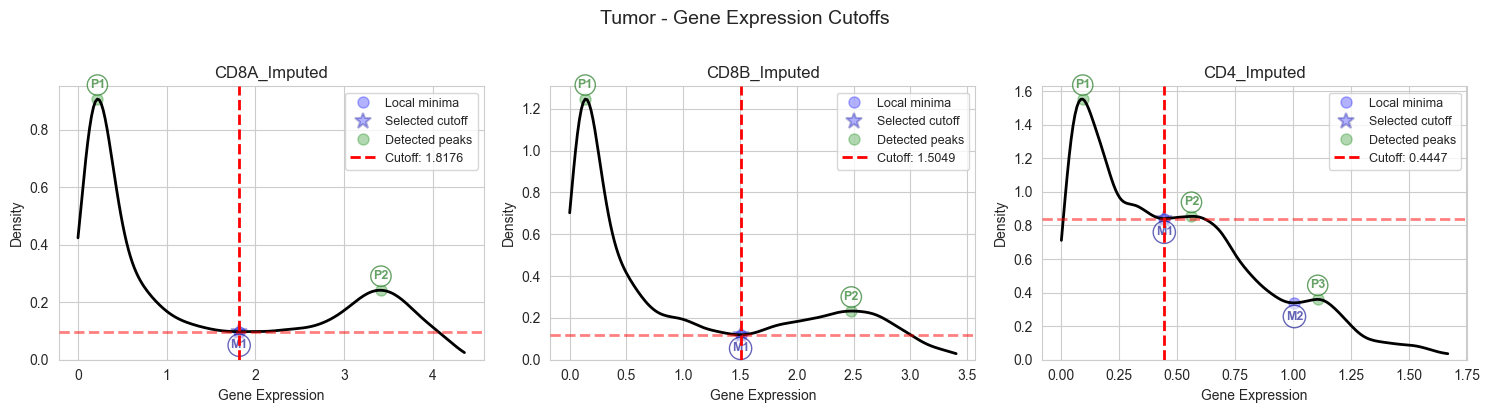

In [38]:
# Determine optimal expression cutoffs for CD8A, CD8B, and CD4 in tumor samples
# It is recommended to visually inspect the plots to ensure cutoffs are appropriate and change bw_adjust if needed
# Please note that using the entire integrated dataset (unlike the single dataset for example shown here), peaks are often better defined (See Figure S1 in our paper)
cutoffs_tumor = plot_cutoffs_for_tissue(
    magic_df_tumor,
    "Tumor",
    ["CD8A_Imputed", "CD8B_Imputed", "CD4_Imputed"],
    bw_adjust=0.8,
)
cd8a_cutoff_tumor = cutoffs_tumor["CD8A_Imputed"]
cd8b_cutoff_tumor = cutoffs_tumor["CD8B_Imputed"]
cd4_cutoff_tumor = cutoffs_tumor["CD4_Imputed"]

In [39]:
# Print calculated tumor cutoffs for verification
print("Calculated Tumor Cutoffs:")
print(f"  CD8A: {cd8a_cutoff_tumor:.8f}")
print(f"  CD8B: {cd8b_cutoff_tumor:.8f}")
print(f"  CD4:  {cd4_cutoff_tumor:.8f}")

Calculated Tumor Cutoffs:
  CD8A: 1.81759586
  CD8B: 1.50485428
  CD4:  0.44470226


#### 3.2.3 Apply Classification to Tumor Samples

Using the determined cutoffs, we classify tumor-infiltrating T cells into subtypes.

In [40]:
# Apply cell type classification to tumor samples using determined cutoffs
magic_df_tumor = classify_tissue_cells(
    magic_df_tumor,
    cd8a_cutoff=cd8a_cutoff_tumor,
    cd8b_cutoff=cd8b_cutoff_tumor,
    cd4_cutoff=cd4_cutoff_tumor,
)

In [41]:
# Save final classified tumor labels to compressed CSV
magic_df_tumor.to_csv(
    source_path / "Brain_zenodo_final_tumor_MAGIC_labels.csv.gz", compression="gzip"
)

### 3.3 Processing Blood (PBMC) Samples

We apply the same MAGIC imputation and classification pipeline to blood samples, using tissue-specific expression cutoffs.

In [42]:
# Subset data to blood (PBMC) samples only
adata_blood = adata[adata.obs["tissue_type"] == "Blood"]

#### 3.3.1 MAGIC Imputation for Blood Samples

Apply MAGIC imputation to blood T cells.

In [43]:
# Normalize and log-transform blood data (target sum = 10,000, log base 2)
sc.pp.normalize_total(adata_blood, target_sum=1e4)
sc.pp.log1p(adata_blood, base=2)

/Users/rona/repos/scXpand-1/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [44]:
# Apply MAGIC imputation to denoise and impute T-cell marker genes in blood
adata_magic_blood = sc.external.pp.magic(
    adata_blood,
    name_list=["CD8A", "CD8B", "CD4", "FOXP3", "CD3E", "PTPRC"],
    random_state=42,
)

/Users/rona/repos/scXpand-1/.venv/lib/python3.13/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


In [45]:
# Combine MAGIC-imputed and original expression values for blood samples
non_imputed_df = sc.get.obs_df(adata_blood, list(adata_magic_blood.var_names))
magic_df_blood = sc.get.obs_df(adata_magic_blood, list(adata_magic_blood.var_names))
magic_df_blood.columns = [f"{col}_Imputed" for col in magic_df_blood.columns]
magic_df_blood = magic_df_blood.join(non_imputed_df)

In [46]:
# Save blood MAGIC labels to compressed CSV
magic_df_blood.to_csv(
    source_path / "Brain_zenodo_MAGIC_labels_blood.csv.gz", compression="gzip"
)

#### 3.3.2 Cutoff Determination for Blood Samples

Determine optimal expression cutoffs specific to blood samples.

  Auto-determined clip range for CD8A_Imputed: [0.000, 3.574]
  Auto-determined clip range for CD8B_Imputed: [0.000, 3.597]
  Auto-determined clip range for CD4_Imputed: [0.000, 0.794]


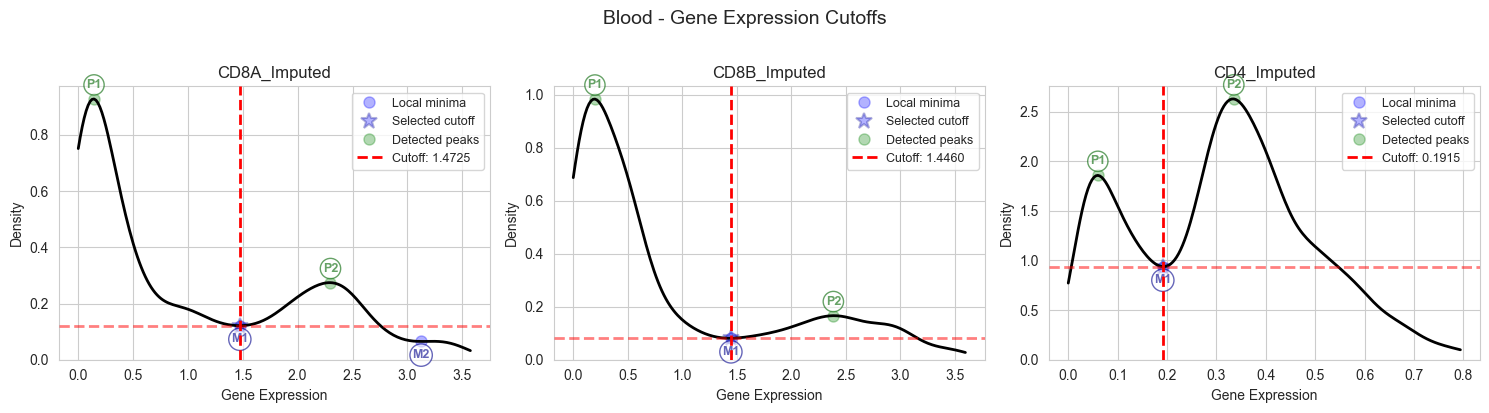

In [47]:
# Determine optimal expression cutoffs for CD8A, CD8B, and CD4 in blood samples
# It is recommended to visually inspect the plots to ensure cutoffs are appropriate and change bw_adjust if needed
# Please note that using the entire integrated dataset (unlike the single dataset for example shown here), peaks are often better defined (See Figure S1 in our paper)
cutoffs_blood = plot_cutoffs_for_tissue(
    magic_df_blood,
    "Blood",
    ["CD8A_Imputed", "CD8B_Imputed", "CD4_Imputed"],
    bw_adjust=1,
)
cd8a_cutoff_blood = cutoffs_blood["CD8A_Imputed"]
cd8b_cutoff_blood = cutoffs_blood["CD8B_Imputed"]
cd4_cutoff_blood = cutoffs_blood["CD4_Imputed"]

In [48]:
# Print calculated blood cutoffs for verification
print("Calculated Blood Cutoffs:")
print(f"  CD8A: {cd8a_cutoff_blood:.8f}")
print(f"  CD8B: {cd8b_cutoff_blood:.8f}")
print(f"  CD4:  {cd4_cutoff_blood:.8f}")

Calculated Blood Cutoffs:
  CD8A: 1.47250224
  CD8B: 1.44599351
  CD4:  0.19146121


#### 3.3.3 Apply Classification to Blood Samples

Classify blood T cells using the determined cutoffs.

In [49]:
# Apply cell type classification to blood samples using determined cutoffs
magic_df_blood = classify_tissue_cells(
    magic_df_blood,
    cd8a_cutoff=cd8a_cutoff_blood,
    cd8b_cutoff=cd8b_cutoff_blood,
    cd4_cutoff=cd4_cutoff_blood,
)

In [50]:
# Save final classified blood labels to compressed CSV
magic_df_blood.to_csv(
    source_path / "Brain_zenodo_final_blood_MAGIC_labels.csv.gz", compression="gzip"
)

## 4. Integration

### 4.1 Integration of scRNA-seq and TCR-seq Annotations

We combine the cell type classifications with TCR information and add study-level metadata.

In [51]:
# Add TCR clonotype and receptor type information to the main AnnData object
adata.obs["clone_id"] = adata_tcr.obs["clone_id"]
adata.obs["receptor_type"] = adata_tcr.obs["receptor_type"]

In [52]:
# Add study metadata: cancer type and publication reference
adata.obs["cancer_type"] = "Brain Tumors"
adata.obs["study"] = "Wang et al. 2024 (Brain)"

In [53]:
# Combine tumor and blood cell type classifications
magic_labels = pd.concat([magic_df_tumor, magic_df_blood])

In [54]:
# Add final cell type labels to the main AnnData object
adata.obs["imputed_labels"] = magic_labels["final_type"]

### 4.2 Patient ID Extraction

Extract patient identifiers from sample names for downstream analysis.

In [55]:
# Extract patient ID from sample names and ensure string types
adata.obs["patient"] = adata.obs["sample"].str.split("_").str[0]
adata.obs["sample"] = adata.obs["sample"].astype(str)
adata.obs["tissue_type"] = adata.obs["tissue_type"].astype(str)

## 5. Clonal Expansion

### 5.1 Clone Size Calculation

We create unique clone identifiers and calculate the size of each clone **per sample**.

In [56]:
# Create unique clone IDs incorporating patient, clonotype, and cell type; calculate clone sizes per sample
# This way, the same clone in different samples obtained from the same patient will have a per-sample size instead of a global size
adata.obs["clone_id"] = (
    adata.obs["patient"].astype(str)
    + "_"
    + adata.obs["clone_id"].astype(str)
    + "_"
    + adata.obs["imputed_labels"].astype(str)
)
adata.obs["clone_id_size"] = adata.obs.groupby(["sample", "clone_id"]).transform("size")

### 5.2 Expansion Status Determination

We classify clones as expanded or non-expanded using the criteria adopted by [Shiao et al.](https://doi.org/10.1016/j.ccell.2023.12.012) and [Shorer et al.](https://doi.org/10.1016/j.xgen.2025.100842):
- A clone is considered **expanded** per sample if its size is > 1.5 times the median clone size in that sample (while excluding singletons from the median calculation)

In [57]:
# Classify clones as expanded or non-expanded using Shiao/shorer et al. criteria (>1.5x median)
# Calculate median clone size per sample
clone_sizes = (
    adata[adata.obs["clone_id_size"] > 1]
    .obs.groupby(["sample", "clone_id"])
    .size()
    .reset_index(name="clone_size")[["sample", "clone_size"]]
)
median_clone_sizes = clone_sizes.groupby("sample").median()
median_clone_sizes["1.5x_median"] = median_clone_sizes["clone_size"] * 1.5
median_clone_sizes = median_clone_sizes.reset_index()

# Merge back to adata
tmp = (
    adata.obs.reset_index()
    .merge(median_clone_sizes, on="sample", how="left")
    .set_index("index")
)
adata.obs["median_clone_size"] = tmp["clone_size"]
adata.obs["1.5x_median_clone_size"] = tmp["1.5x_median"]

# Vectorized expansion classification:
adata.obs["expansion"] = np.where(
    adata.obs["1.5x_median_clone_size"] < adata.obs["clone_id_size"],
    "expanded",
    "non_expanded",
)

## 6. Export

### 6.1 Gene Name Reorganization for Model Training

Reorganize gene names as ensembl_ids for compatibility with downstream tools.

In [58]:
# Reorganize gene metadata to use ensembl_ids as index with gene names as column
adata.var = adata.var.rename_axis("gene_name").reset_index().set_index("gene_ids")

### 6.2 Save Processed Data

Save the fully processed AnnData object containing:
- Raw and normalized expression data
- Cell type annotations
- TCR information and clonotypes
- T-cell clonal expansion status
- All relevant metadata

**Note**: Uncomment the save line below to export the processed data.

In [59]:
# Display counts of expanded vs non-expanded cells by tissue type and sample
adata.obs.groupby(["tissue_type", "sample", "expansion"]).size()

tissue_type  sample         expansion   
Blood        G4A112Re_PBMC  expanded         324
                            non_expanded     795
             GBM106_PBMC    expanded         272
                            non_expanded    2678
             GBM111Re_PBMC  expanded          30
                            non_expanded     560
             GBM113_PBMC    expanded         409
                            non_expanded     581
             GBM114_PBMC    expanded          45
                            non_expanded     344
Tumor        BrMet009       expanded         621
                            non_expanded     397
             BrMet010       expanded         228
                            non_expanded     684
             BrMet018       expanded         232
                            non_expanded    1352
             BrMet027       expanded         737
                            non_expanded    2158
             BrMet028       expanded         135
                            

In [60]:
# Save the fully processed AnnData object (commented out - uncomment to save)
# adata.write(os.path.join(source_path, "scXpand_preprocessed_data_Brain_zenodo.h5ad"), compression = 'gzip')